# Predicting YouTube views: Large-language models

In the [previous notebooks](https://github.com/tommyliphysics/tommyli-ml/blob/main/youtube_predictor/notebooks/embedding.ipynb) we evaluated classical ML models based on tfidf-vectorisation and vector embeddings. Now we can explore another approach: a pre-trained LLM. For this task we'll be using distilBERT, a compact version of Google's BERT model. We will combine four text features -- the video category, the channel title, the video title and the video description -- as the input to the model.  Let's import the training data and fill NA values with empty strings.

In [ ]:
#pip install --upgrade transformers

In [ ]:
#!pip install tf-keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [ ]:
import pandas as pd

samples = pd.read_csv('https://raw.githubusercontent.com/tommyliphysics/tommyli-ml/main/youtube_predictor/data/train.csv', lineterminator='\n')
samples

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,BKTVOK,22,BAWAR KHAN SON MUHAMMAD Khan Short video YouT...,Bawarkhan SON MUHAMMAD khan \nAmazing Videos\n...,19,1.982271,0
1,Rockit14,20,Add realistic waves to Minecraft! (Physics Mod),Play Minecraft with realistic physics! This mi...,11,5.338389,1
2,MAD ABOUT SCIENCE,22,The Stirling Engine at my Institute,Very close to Carnot Engine\n\n This one is...,50,5.685385,1
3,BKTVOK,22,Shergarh Bazar video YouTube amazing viralvide...,Shergarh Bazar video YouTube amazing viralvide...,21,2.287802,0
4,HVTraining,17,Cycling Tips: The science of electrolytes and ...,Looking for a proven training plan? \nhttps://...,72,3.307282,0
...,...,...,...,...,...,...,...
25323,Khanish,22,Friction welding #tools #science #viral,Friction welding is a solid-state welding proc...,57,3.766115,0
25324,TungaloyCorporation,28,We made a smile with high feed machining! #cn...,Product : AddDoFeed\nShank : VSSD08L090S05-C\n...,2,5.627098,1
25325,Sansad TV,25,Science Monitor | 14.08.2021,1.HUMAN-BASED MODELS TO STUDY NEURODEVELOPMENT...,32,4.421341,0
25326,The Truth Show,27,Trick for Reactivity Series of Metals #shorts ...,Join our Telegram Group ATP STAR JEE/NEET 2024...,18,6.748217,1


In [ ]:
samples = samples.fillna('')

The video categories have been represented by an integer value, but we will convert them into text.

In [ ]:
video_categories = {1: 'Film & Animation',
                    2: 'Autos & Vehicles',
                    10: 'Music',
                    15: 'Pets & Animals',
                    17: 'Sports',
                    19: 'Travel & Events',
                    20: 'Gaming',
                    22: 'People & Blogs',
                    23: 'Comedy',
                    24: 'Entertainment',
                    25: 'News & Politics',
                    26: 'Howto & Style',
                    27: 'Education',
                    28: 'Science & Technology',
                    29: 'Nonprofits & Activism'}

samples['video_category'] = samples['video_category'].apply(lambda category: video_categories[category])

Next, we will perform an 80/20 train/validation split for the purpose of tuning the learning rate scheduler:

In [ ]:
val = samples.sample(frac=0.2, random_state=524)
train = samples.drop(val.index)

In [ ]:
train

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,BKTVOK,People & Blogs,BAWAR KHAN SON MUHAMMAD Khan Short video YouT...,Bawarkhan SON MUHAMMAD khan \nAmazing Videos\n...,19,1.982271,0
1,Rockit14,Gaming,Add realistic waves to Minecraft! (Physics Mod),Play Minecraft with realistic physics! This mi...,11,5.338389,1
2,MAD ABOUT SCIENCE,People & Blogs,The Stirling Engine at my Institute,Very close to Carnot Engine\n\n This one is...,50,5.685385,1
3,BKTVOK,People & Blogs,Shergarh Bazar video YouTube amazing viralvide...,Shergarh Bazar video YouTube amazing viralvide...,21,2.287802,0
4,HVTraining,Sports,Cycling Tips: The science of electrolytes and ...,Looking for a proven training plan? \nhttps://...,72,3.307282,0
...,...,...,...,...,...,...,...
25323,Khanish,People & Blogs,Friction welding #tools #science #viral,Friction welding is a solid-state welding proc...,57,3.766115,0
25324,TungaloyCorporation,Science & Technology,We made a smile with high feed machining! #cn...,Product : AddDoFeed\nShank : VSSD08L090S05-C\n...,2,5.627098,1
25325,Sansad TV,News & Politics,Science Monitor | 14.08.2021,1.HUMAN-BASED MODELS TO STUDY NEURODEVELOPMENT...,32,4.421341,0
25326,The Truth Show,Education,Trick for Reactivity Series of Metals #shorts ...,Join our Telegram Group ATP STAR JEE/NEET 2024...,18,6.748217,1


In [ ]:
val

,channel_title,video_category,video_title,video_description,months,video_view_count,label
11683,CrashCourse,Education,Micro-Biology: Crash Course History of Science...,It's all about the SUPER TINY in this episode ...,66,5.778978,1
14892,Padhle Tenthies,Education,Chemical Reactions and Equations Class 10 Scie...,Chemical Reactions and Equations Class 10 Scie...,23,5.384982,1
21540,Coding with Lewis,Science & Technology,What code editor should you use? 👩‍💻 #technolo...,,21,6.074111,1
4075,Hitesh Gohel,People & Blogs,Redox reaction class 11th Science gujarati,Balancing Redox reaction in acidic medium,60,4.482845,0
2171,MCQ Questions Hub,Education,Magnetism (चुम्बकत्व) MCQ | Physics MCQ | MCQ ...,Magnetism (चुम्बकत्व) MCQ | Physics MCQ | MCQ ...,35,3.995591,0
...,...,...,...,...,...,...,...
23360,Espiri Ibarra,People & Blogs,"October 9, 2022",,18,0.301030,0
11858,Happy Day,People & Blogs,Kirchhoff's Law,Kirchhoff’s Law-Pfis19-2B-Mohammad Nafis Nailu...,46,2.607455,0
12996,Book Scribe,Education,NCERT Science Class 6 தமிழ் | Chapter 13 | Fun...,NCERT Science Class 6 - Chapter 13: Fun with m...,27,3.859559,0
7290,OBD Việt Nam - Dịch vụ TỪ XA,Autos & Vehicles,Introduction SCR (Selective catalytic reductio...,#obdvietnam #service \n-----------------------...,1,1.568202,0


We will now define functions to import the pre-trained model from the huggingface transformers library.

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from transformers import DistilBertTokenizerFast

def get_tokenizer_model():
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
    return tokenizer,model

In [ ]:
tokenizer,model = get_tokenizer_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

We will use keras to fine-tune the pre-trained models. Let's define a function that prepares text samples for training, and then prepare the training and validation data.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

sep_token = tokenizer.convert_tokens_to_ids('[SEP]')
cls_token = tokenizer.convert_tokens_to_ids('[CLS]')

def create_dataset(samples, train=True):
    encodings = {col: tokenizer(samples[col].tolist(), add_special_tokens=False)['input_ids'] for col in ['channel_title', 'video_title', 'video_description', 'video_category']}
    encodings = [[cls_token] + channel_title + [sep_token] + video_title + [sep_token] + video_description + [sep_token] + video_category + [sep_token]
                  for channel_title, video_title, video_description, video_category
                  in zip(encodings['channel_title'], encodings['video_title'], encodings['video_description'], encodings['video_category'])]
    encodings = pad_sequences(encodings, maxlen=tokenizer.model_max_length, padding='post', truncating='post', value=tokenizer.pad_token_id)

    if train:
        return tf.data.Dataset.from_tensor_slices((encodings,samples['label'].tolist())).shuffle(len(samples)).batch(16)
    else:
        return tf.data.Dataset.from_tensor_slices(encodings)

In [ ]:
train_dataset = create_dataset(train)
val_dataset = create_dataset(val)

Next we can define our functions to compile and train the model.

In [ ]:
import numpy as np

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler

import math

import keras
from keras.callbacks import Callback

last_epoch = 0

def compile_model(model):
    model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                  metrics = ['accuracy'])
    model.config.id2label = {0: 'under 50k views', 1: 'over 50k views'}

def fit_model(model):
    history = model.fit(train_dataset,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[LearningRateScheduler(lr_scheduler),
                   EarlyStopping(monitor="val_loss", patience=3)],
        validation_data=val_dataset,
        verbose=1)



We can now compile and fine tune the keras model. We'll start training with a "warm-up" period where the learning rate decreases from 10$^{-4}$ to 10$^{-6}$ over five epochs, then continue training at 10$^{-6}$ unless the validation loss ceases to decrease.

In [ ]:
learning_rate = 1e-4
compile_model(model)

In [ ]:
def lr_scheduler(epoch, lr):
    if epoch < 6:
        return learning_rate*(0.01**(epoch/5))
    else:
        return 1e-6

In [ ]:
epochs = 9
batch_size=128

In [ ]:
fit_model(model)

Epoch 1/9


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1267/1267 [==============================] - 1295s 993ms/step - loss: 0.5887 - accuracy: 0.6855 - val_loss: 0.5215 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 2/9
1267/1267 [==============================] - 1253s 989ms/step - loss: 0.4747 - accuracy: 0.7790 - val_loss: 0.5027 - val_accuracy: 0.7598 - lr: 3.9811e-05
Epoch 3/9
1267/1267 [==============================] - 1253s 989ms/step - loss: 0.3936 - accuracy: 0.8273 - val_loss: 0.4693 - val_accuracy: 0.7892 - lr: 1.5849e-05
Epoch 4/9
1267/1267 [==============================] - 1253s 989ms/step - loss: 0.3333 - accuracy: 0.8575 - val_loss: 0.4825 - val_accuracy: 0.7906 - lr: 6.3096e-06
Epoch 5/9
1267/1267 [==============================] - 1253s 989ms/step - loss: 0.2983 - accuracy: 0.8746 - val_loss: 0.5160 - val_accuracy: 0.7917 - lr: 2.5119e-06
Epoch 6/9
1267/1267 [==========================

We see that the validation loss stopped decreasing after the 3rd epoch. We can train a final model using the full dataset for 3 epochs with the same learning rate scheduling.

In [ ]:
tokenizer,model_final = get_tokenizer_model()
train_dataset_full = create_dataset(samples)
epochs = 3
batch_size=128

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
compile_model(model_final)

history = model_final.fit(train_dataset_full,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1583/1583 [==============================] - 1602s 987ms/step - loss: 0.5874 - accuracy: 0.6798
Epoch 2/3
1583/1583 [==============================] - 1569s 991ms/step - loss: 0.4905 - accuracy: 0.7672
Epoch 3/3
1583/1583 [==============================] - 1567s 990ms/step - loss: 0.4285 - accuracy: 0.8103


We can now evaluate our final model on the test data.



In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/tommyliphysics/tommyli-ml/main/youtube_predictor/data/test.csv', lineterminator='\n')
test

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,RG LECTURES,27,MHTCET FULL REVISION ONE SHOT ALL FORMULAS - P...,MHTCET PHYSICS FULL COMPLETE ONE SHOT REVISION...,11,5.238984,1
1,FuTechs,28,Tony Robbin and Robot conversation Relationshi...,"Speaker :Anthony Jay Robbins (né Mahavoric, bo...",10,4.364063,0
2,That Chemist,27,Nobel Prize in Chemistry 2022 (Recap),The Nobel Prize in Chemistry for 2022 has been...,18,4.484656,0
3,SCIENCE FUN For Everyone!,27,Friction Fun Friction Science Experiment,Have fun exploring friction with this easy sci...,36,4.503437,0
4,Michigan Medicine,26,Deconstructing the Legitimization of Acupunctu...,"Rick Harris, PhD\nAssociate Professor, Anesthe...",57,4.632467,0
...,...,...,...,...,...,...,...
6328,CARB ACADEMY,27,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,16,5.496467,1
6329,Rafael Verdonck's World,22,Science World #7 Will Strangelets destroy th...,Will the universe be destroyed by a tiny eleme...,70,3.183270,0
6330,Trik Matematika mesi,27,deret angka matematika #shorts #maths,NaN,19,5.764919,1
6331,edureka!,27,Statistics And Probability Tutorial | Statisti...,🔥 Data Science Certification using R (Use Code...,59,5.561255,1


In [ ]:
test = test.fillna('')
test['video_category'] = test['video_category'].apply(lambda category: video_categories[category])
test_dataset = create_dataset(test, train=False)

In [ ]:
final_model_output = model_final.predict(test_dataset)

6333/6333 [==============================] - 132s 20ms/step


In [ ]:
y_proba = tf.nn.sigmoid(final_model_output.logits).numpy()
y_proba = y_proba.T[1]

In [ ]:
y_pred = y_proba > 0.5

In [ ]:
from sklearn.metrics import *

y_test = test['label']

cm = confusion_matrix(y_test, y_pred)

metrics = {'accuracy': accuracy_score(y_test, y_pred),
           'precision': precision_score(y_test, y_pred),
           'recall': recall_score(y_test,y_pred),
           'f1': f1_score(y_test,y_pred)}

In [ ]:
display(pd.DataFrame(cm,columns=['predicted under 50k views','predicted over 50k views'],index = ['under 50k views','over 50k views']))

,predicted under 50k views,predicted over 50k views
under 50k views,3278,554
over 50k views,771,1730


In [ ]:
display(pd.DataFrame([metrics]))

,accuracy,precision,recall,f1
0,0.790778,0.757443,0.691723,0.723093


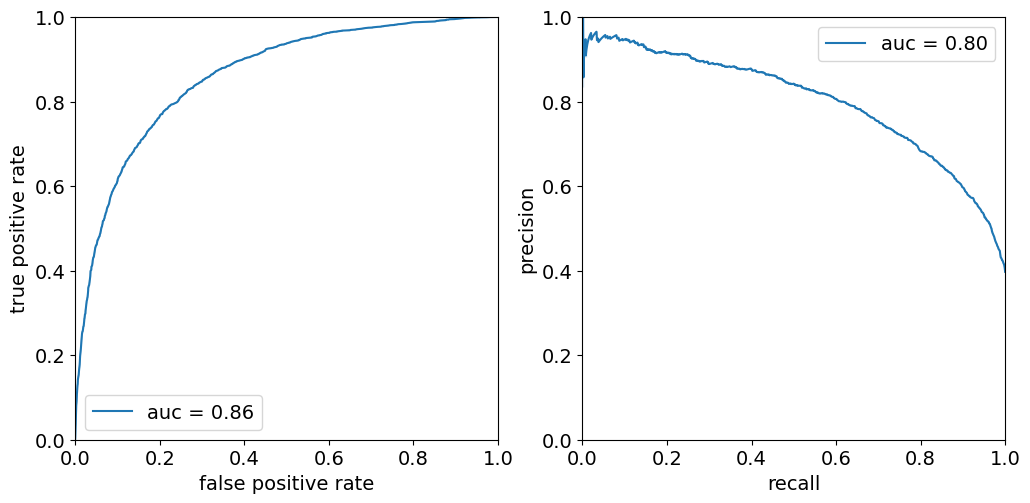

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(12,8))

fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

sns.lineplot(x=fpr, y=tpr, ax = axes[0], label=f'auc = {roc_auc:.2f}')
sns.lineplot(x=recall, y=precision, ax = axes[1], label=f'auc = {pr_auc:.2f}')

axes[0].set_xlabel("false positive rate", fontsize=14)
axes[0].set_ylabel("true positive rate", fontsize=14)
axes[0].set_xlim([0,1])
axes[0].set_ylim([0,1])
axes[0].set_aspect('equal', adjustable='box')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=14)

axes[1].set_xlabel("recall", fontsize=14)
axes[1].set_ylabel("precision", fontsize=14)
axes[1].set_xlim([0,1])
axes[1].set_ylim([0,1])
axes[1].set_aspect('equal', adjustable='box')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=14)

plt.show()

In the [previous notebooks](https://github.com/tommyliphysics/tommyli-ml/blob/main/youtube_predictor/notebooks/embedding.ipynb) we looked at classical machine learning models with two different vectorisation approaches: TF-IDF and vector embeddings taken from a pre-trained LLM. Our current model, a transformer that was pre-trained on a large dataset and fine tuned on a smaller, specialised dataset, exhibits similar but very slightly worse metrics on the test data. It is possible that the performance could be improved by finer tuning of the learning rate scheduler, but considering that we have now seen three very distinct ML approaches yielding very similar results, it seems like an accuracy in the low 80s is simply a statistical limit determined by the predictive power of the chosen features.